In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, get_1_dev_irr, first_dev_matrix, r_ghost, sA_ghost, A_ghost

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [2]:
μ = 2.34    #(Hayashi 1981)
r = r_array * u.au

def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)

def temp(r, T_1au= 280 * u.K, p = -1/2):
    return T_1au * (r / (1 * u. au))**p

def soundspeed(r):
    return np.sqrt((k_B * temp(r)) / (μ * m_p))

In [3]:
temp(r), soundspeed(r).to('m/s')

(<Quantity [2.80000000e+03, 2.73252020e+03, 2.66819814e+03, ...,
            2.80076363e+00, 2.80006351e+00, 2.79936374e+00] K>,
 <Quantity [3142.7789515 , 3104.67761992, 3067.91878492, ...,   99.39694792,
              99.3845238 ,   99.37210433] m / s>)

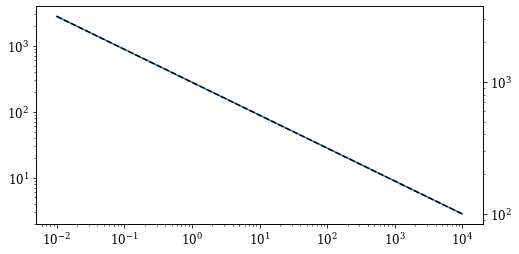

In [4]:
fig, axs = plt.subplots(figsize = (8,4))
axs.loglog(r, temp(r))

axs2 = axs.twinx()
axs2.loglog(r, soundspeed(r), ls='--', c = 'black')

In [5]:
α_rφ = 8e-3

def alpha_test(Σ):
    
    inner_1 = Σ * r**(2)
    inner_2 = α_rφ * soundspeed(r)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    print(inner_dev.unit)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)
    print((r**(-1)*outer_dev).unit)
    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

In [6]:
alpha_test(Σ_initial(r))

AU2 g J / (cm2 kg)
AU(3/2) g J s / (cm2 kg m(3/2))


<Quantity [-3.16792440e+004, -2.94440809e+004, -2.74119124e+004, ...,
            4.37577868e-147,  3.68510107e-147,  3.03491923e-147] mg / (cm2 yr)>

In [7]:
def one_alpha(t, Σ):
    Σ = Σ *  u.g * u.cm**-2
    r_ghost_au = r_ghost * u.au
    r_au = r_array * u.au
    Σ = Σ_initial(r_au)

    inner = r_au**2 * Σ * α_rφ * soundspeed(r_au)**2
    inner_unit = inner.unit

    ghost_1 = np.array([inner[1].value])
    ghost_2 = np.array([inner[-2].value])

    inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit

    outer_ghost = 2 / (r_ghost_au * Omega_kep(r_ghost_au)) * (A_ghost @ inner_ghost)
    
    sec_dev = 1/r_ghost_au * (A_ghost @ outer_ghost)

    df_dt = (sec_dev[1: -1] * u.au**(-2)).to('mg/(yr * cm^2)')

    return df_dt.value 

In [8]:
times = np.arange(0, 1001, 1)
sol = solve_ivp(one_alpha, [times[0], times[-1]], y0 = Σ_initial(r).value, method = 'LSODA', t_eval = times, atol=1e-4, rtol=1e-6)

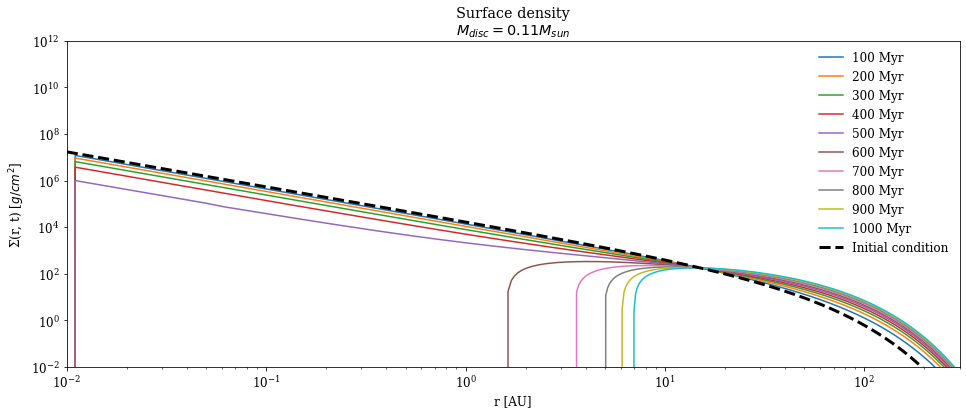

In [9]:
fig, axs = plt.subplots(figsize = (16,6))

for i in np.linspace(1e2, 1e3, 10):
    axs.loglog(r_array, sol.y[:, sol.t == i], label = f'{i:1.0f} Myr')


axs.plot(r_array, Σ_initial(r), ls='--', lw=3, c='black', label = 'Initial condition')

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e12), xlim = (0.01, 300))
plt.legend(frameon=False, loc='upper right' )

[0.01       0.0105     0.01101235 0.01153705 0.0120741  0.01262351] AU
[16994334.27767285 15794757.7625985  14705156.06755187 13713236.24001652
 12808315.29058056 11981079.81635989] g / cm2


Unit("g / cm2")

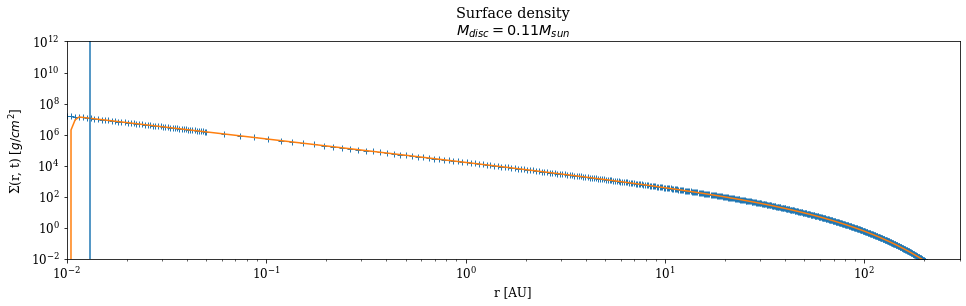

In [10]:
fig, axs = plt.subplots(figsize = (16,4))

axs.semilogx(r, Σ_initial(r), '+')
initial_new = Σ_initial(r).copy()
initial_new[0] = 0
initial_new[1] = 2e6 * Σ_initial(r).unit
initial_new[2] = 0.9e7 * Σ_initial(r).unit

axs.semilogx(r, initial_new, '-')

axs.axvline(1.3e-2)

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e12), xlim = (0.01, 300))

print(r[r.value < 1.3e-2])
print(Σ_initial(r)[r.value < 1.3e-2])
Σ_initial(r).unit

In [11]:
times = np.arange(0, 1001, 1)
sol2 = solve_ivp(one_alpha, [times[0], times[-1]], y0 = initial_new.value, method = 'LSODA', t_eval = times, atol=1e-4, rtol=1e-6)

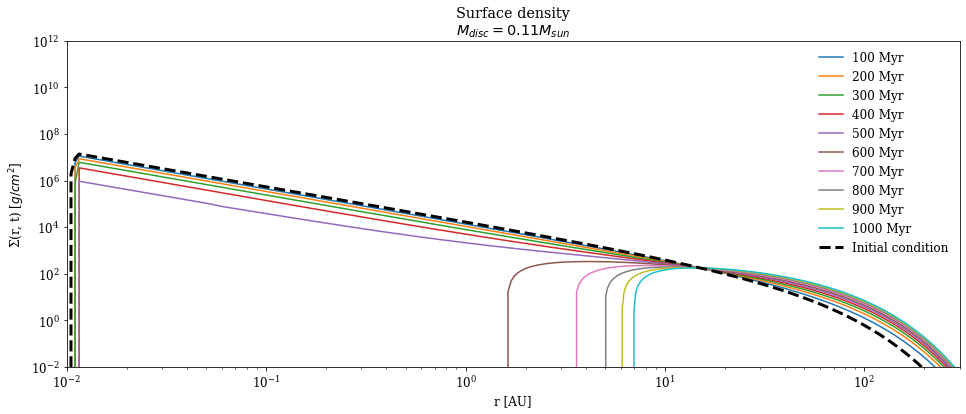

In [12]:
fig, axs = plt.subplots(figsize = (16,6))

for i in np.linspace(1e2, 1e3, 10):
    axs.loglog(r_array, sol2.y[:, sol.t == i], label = f'{i:1.0f} Myr')


axs.plot(r_array, initial_new, ls='--', lw=3, c='black', label = 'Initial condition')

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e12), xlim = (0.01, 300))
plt.legend(frameon=False, loc='upper right' )